In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install plot-metric

In [ ]:
!pip install scipy==1.11.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
import pandas as pd
import numpy as np
import warnings
import joblib
import plotly.express as px
from google.colab import drive
from datetime import date, timedelta
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from plot_metric.functions import BinaryClassification

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 500

from google.colab import auth
import gspread
from google.auth import default

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
CORE_INV_URL = 'https://docs.google.com/spreadsheets/d/1GIPBNgCTbgf-82-W1wLDOfd-zgRasmKSci12UNIDJJs/edit?gid=0#gid=0'
CORE_INV_SHEET = 'Final Core Consolidation (2022-23-24)'

OFFER_URL = 'https://docs.google.com/spreadsheets/d/113FPteQQhW-YmPSuok57AVdOFM4D0lSSwKp22Z5mA7E/edit#gid=977984480'
OFFER_SHEET = 'Offers Breakdown'

NON_CORE_INV_URL = 'https://docs.google.com/spreadsheets/d/1Skx5aUfUDKPlR07ghDSca7nrR0rTb2pMSOvnxhDKYF8/edit#gid=15358136'
NON_CORE_INV_SHEET = 'Inventory  Consolidation NC'

In [ ]:
def read_input_data(CORE_INV_URL, CORE_INV_SHEET, OFFER_URL, OFFER_SHEET):
  spr = gc.open_by_url(CORE_INV_URL)
  wks = spr.worksheet(CORE_INV_SHEET)
  rows = wks.get_all_values()
  df_inv = pd.DataFrame.from_records(rows)
  df_inv = df_inv.rename(columns=df_inv.iloc[0]).iloc[1:].reset_index(drop = True)

  spr = gc.open_by_url(OFFER_URL)
  wks = spr.worksheet(OFFER_SHEET)
  rows = wks.get_all_values()
  df_offer = pd.DataFrame.from_records(rows)
  df_offer = df_offer.rename(columns=df_offer.iloc[0]).iloc[1:].reset_index(drop = True)

  return df_inv, df_offer

In [ ]:
def read_non_core_inv_data(NON_CORE_INV_URL, NON_CORE_INV_SHEET):
  spr = gc.open_by_url(NON_CORE_INV_URL)
  wks = spr.worksheet(NON_CORE_INV_SHEET)
  rows = wks.get_all_values()
  non_core_inv = pd.DataFrame.from_records(rows)
  non_core_inv = non_core_inv.rename(columns=non_core_inv.iloc[0]).iloc[1:].reset_index(drop = True)

  return non_core_inv

In [ ]:
df_inv, df_offer = read_input_data(CORE_INV_URL, CORE_INV_SHEET, OFFER_URL, OFFER_SHEET)

In [ ]:
non_core_inv = read_non_core_inv_data(NON_CORE_INV_URL, NON_CORE_INV_SHEET)

In [ ]:
non_core_inv.Seller.unique()

array(['Acommerce Singapore', 'Acommerce Thailand', 'Blackmores Malaysia',
       'Blackmores Singapore', 'Coca Cola JP', 'Dew It', 'Elite Matrix',
       'Ginjo', 'Good Earth Dolls Singapore', 'Half Phase', 'Hysiry',
       'Loot Chest', 'STOCKXWERK e.K.', 'Vinculum Group', 'League Shoes',
       'ZEESEA', 'Halo Company', 'Ginzai', 'Kokubu Commonwealth',
       'Noble Trend International', 'UNA Brands', 'Rainforest', 'Eblo',
       'Sainhall Nutrihealth Pte Ltd', 'Premier Distribution',
       'Skai Beauty', 'BitLoop', 'Yin Kwee Trading ',
       'Thursday Plantation', 'Kids Treasures', 'Thomas Sabo',
       'Branded Watches (Hong Kong)', 'INH Hair', 'Ora', 'Tionale',
       'Baby Shop', 'SIRCLO', 'Markato', 'DEW IT', 'Crown Affair',
       'Naturopathica', 'Borwita', 'Authentique  Groupe', 'EBLO',
       'playnation', 'Revolution Beauty', 'Celsius'], dtype=object)

In [ ]:
def column_rename(df, column_list):
  for i in column_list:
    new_col = i.lower().replace(' ', '_').replace('-', '_').replace('/', '_')
    if new_col != '':
      if new_col[0] == '_':
        new_col = new_col[1:]
      if new_col[-1] == '_':
        new_col = new_col[:-1]
    df.rename(columns = {i : new_col}, inplace = True)
  return df

def cols_to_lower_rem_space(df, cols_list):
  for col in ['sku_name', 'product_name', 'brand', 'brand_', 'product_description', 'product_category', 'product_sub_category', 'product_subcategory',\
              'warehouse_location', 'buyer', 'seller', 'package_type', 'deal_type', 'origin_', 'destination', 'pack_label_language', 'region_of_export', \
              'domestic_export', 'order_type', 'country', 'currency', 'country_of_origin', 'pack_label_language', 'dangerous_goods\n(y/n)', 'shelf_life_bucket',
              'relavant_(r)/ir-relavant(ir)', 'product_restricted_countries', 'store_name', 'quarter', 'temp_reference', 'tracking_no', 'offer_type', 'fiscal_month',
              'pollen_product_category', 'pollen_product_subcategory', 'name', 'unit_dimension', 'warehouse_address', 'warehouse_country', 'priority',
              'country_of_orgin', 'pack_size_(unit)']:
              if col in cols_list:
                df[col] = df[col].str.lower().str.replace(' ', '_')
  return df

In [ ]:
df_offer = column_rename(df_offer, df_offer.columns)
df_offer = cols_to_lower_rem_space(df_offer, df_offer.columns)
df_inv = column_rename(df_inv, df_inv.columns)
df_inv = cols_to_lower_rem_space(df_inv, df_inv.columns)

non_core_inv = column_rename(non_core_inv, non_core_inv.columns)
non_core_inv = cols_to_lower_rem_space(non_core_inv, non_core_inv.columns)

In [ ]:
df_inv = df_inv.rename(columns= {'retail_price_per_unit_\n(_local_)' : 'retail_price_per_unit_local', 'asking_price_per_unit\n(_local_)' : 'asking_price_per_unit_local',
                         'retail_price_per_unit_\n_(_usd_)' : 'retail_price_per_unit_usd', 'asking_price_per_unit\n(_usd_)' : 'asking_price_per_unit_usd',
                          'total_number_of_items' : 'total_units'})
non_core_inv = non_core_inv.rename(columns= {'retail_price_per_unit_\n(_local_)' : 'retail_price_per_unit_local',
                                             'asking_price_per_unit\n(_local_)' : 'asking_price_per_unit_local',
                                             'retail_price_per_unit_\n_(_usd_)' : 'retail_price_per_unit_usd',
                                             'asking_price_per_unit\n(_usd_)' : 'asking_price_per_unit_usd',
                                             'total_number_of_items' : 'total_units'})

df_inv = df_inv.drop(['cateogry_(legacy)', 'sub_category_(legacy)', 'manufactured_date', 'batch_numer', 'image_links', 'scoring', 'usd_conversion',
                      'inventory___old___new', 'barcode', 'barcode_key'], axis = 1)
non_core_inv = non_core_inv.drop(['cateogry_(legacy)', 'sub_category_(legacy)', 'manufactured_date', 'batch_numer', 'image_links', 'scoring', 'usd_conversion',
                                  'inventory___old___new', 'barcode', 'barcode_key'], axis = 1)

df_offer = df_offer.rename(columns = {'deal_type' : 'domestic_export', 'brand_' : 'brand', 'origin' : 'origin_inv'})

In [ ]:
def remove_starting_and_trailing_underscores(x):
  if x != '':
    if x[0] == '_':
      for i in range(len(x)):
        if x[i] != '_':
          start = i
          break
      x = x[start:]
    if x[-1] == '_':
      for i in reversed(range(len(x))):
        if x[i] != '_':
          end = i
          break
      x = x[:end+1]
  return x

In [ ]:
def cleaning_underscores_inv_data(df_inv, col_list):
  for col in col_list:
    df_inv[col] = df_inv[col].apply(remove_starting_and_trailing_underscores)
  return df_inv

In [ ]:
cols_list_underscore_cleaning = ['name', 'package_type', 'brand', 'product_category', 'product_subcategory', 'warehouse_address', 'warehouse_country',
            'country_of_orgin', 'package_labeled_language', 'product_restriction']

df_inv = cleaning_underscores_inv_data(df_inv, cols_list_underscore_cleaning)

In [ ]:
print('Inv - ', df_inv.shape, 'Offer - ', df_offer.shape)
print('Inventory dups - ', df_inv.duplicated().sum())

Inv -  (61258, 34) Offer -  (17065, 43)
Inventory dups -  2123


In [ ]:
def drop_dups_and_clean(df_inv):
  print('Dropping above duplicates ...')
  df_inv = df_inv.drop_duplicates()
  return df_inv

df_inv = drop_dups_and_clean(df_inv)

Dropping above duplicates ...


In [ ]:
def get_priority_for_offers(x):
  return x.split('_')[0][1:3]

df_offer['shelf_life_bucket'] = df_offer.shelf_life_bucket.astype(str)
df_offer['priority_order'] = df_offer.shelf_life_bucket.apply(get_priority_for_offers)
df_inv['priority_order'] = df_inv.priority.apply(get_priority_for_offers)
non_core_inv['priority_order'] = df_inv.priority.apply(get_priority_for_offers)

In [ ]:
def inv_dups_drop_plus_offer_status(df_inv, df_offer):
  print('Inv dups on a combo of sku, expiry_date, warehouse_address, record_date -', df_inv.duplicated(subset = ['sku', 'expiry_date', 'warehouse_address', 'record_date']).sum())
  df_inv = df_inv.drop_duplicates(subset = ['sku', 'expiry_date', 'warehouse_address', 'record_date'])

  print('Offer shape - ', df_offer.shape)
  print('Offer dups - ', df_offer[['sku_number', 'expiry_date', 'tracking_no']].duplicated().sum())
  print('Duplicates on sku_number, expiry_date, tracking_no combos occuring due to different batch numbers')
  return df_inv

In [ ]:
df_inv = inv_dups_drop_plus_offer_status(df_inv, df_offer)

Inv dups on a combo of sku, expiry_date, warehouse_address, record_date - 2677
Offer shape -  (17065, 44)
Offer dups -  1878
Duplicates on sku_number, expiry_date, tracking_no combos occuring due to different batch numbers


In [ ]:
def do_datatype_conversion(df_inv, df_offer, non_core_inv):
  df_inv['total_units'] = df_inv['total_units'].str.replace(',', '')
  df_inv = df_inv[~df_inv['total_units'].isin(['', '-'])]
  df_inv['total_units'] = df_inv['total_units'].astype(float)
  df_inv = df_inv[~df_inv['expiry_date'].isin(['-', 'P1', 'P2', 'P3', 'MTO', 'Greater than Year'])]
  df_inv['expiry_date'] = pd.to_datetime(df_inv['expiry_date'])
  df_inv = df_inv[~df_inv.record_date.isin(['20- Dec- 2023'])]
  df_inv['record_date'] = pd.to_datetime(df_inv['record_date'], format = "%d-%b-%Y")

  non_core_inv['expiry_date'] = np.where(non_core_inv['expiry_date'].isin(['-', '31-Dec-4712']), np.nan, non_core_inv['expiry_date'])
  non_core_inv['expiry_date'] = pd.to_datetime(non_core_inv['expiry_date'], format = "%d-%b-%Y")
  non_core_inv['record_date'] = pd.to_datetime(non_core_inv['record_date'])

  df_offer['total_units'] = df_offer['total_units'].str.replace(',', '')
  df_offer = df_offer[df_offer['total_units'] != '']
  df_offer['total_units'] = df_offer['total_units'].astype(float)
  df_offer = df_offer[df_offer['expiry_date'] != '-']
  df_offer['expiry_date'] = pd.to_datetime(df_offer['expiry_date'], format = "%d-%b-%Y")
  df_offer['date_of_offer'] = pd.to_datetime(df_offer['date_of_offer'])

  return df_inv, df_offer, non_core_inv

In [ ]:
df_inv, df_offer, non_core_inv = do_datatype_conversion(df_inv, df_offer, non_core_inv)

In [ ]:
inv_cols_list_to_change_dtypes = ['qty_of_carton', 'units_per_package_type', 'retail_price_per_unit_local', 'asking_price_per_unit_local', 'retail_price_per_unit_usd',
                              'asking_price_per_unit_usd', 'pack_size_(number)', 'cbm_carton', 'length', 'breadth',	'height', 'weight_per_carton_(kg)']

non_core_inv_cols_list_to_change_dtypes = ['total_units', 'qty_of_carton', 'units_per_package_type', 'retail_price_per_unit_local', 'asking_price_per_unit_local', 'retail_price_per_unit_usd',
                              'asking_price_per_unit_usd', 'pack_size_(number)', 'cbm_carton', 'length', 'breadth',	'height', 'weight_per_carton_(kg)']

offer_cols_list_to_change_dtypes = ['retail_price_unit_(usd)', 'retail_price_carton_(usd)', 'total_retail_price_(usd)',
                                    'asking_price_carton_(usd)', 'total_asking_price_(usd)', 'offer_price_unit_(usd)', 'total_offer_price_(usd)',
                                    'gross_weight_package_type_(kg)', 'total_gross_weight_(kg)', 'cbm_package_type', 'recovery_rate_(retail)', 'recovery_rate_(asking)',
                                    'discount_%']

# try imputing to reduce data loss

def change_dtype(df, feat):
  # '', '-'
  df[feat] = df[feat].str.replace(' ', '').str.replace(',', '').str.replace('$', '').str.replace('%', '').str.replace('G', '')
  df = df[~df[feat].isin(['#DIV/0!', '$0.1000', '$0.67', '#VALUE!', '#N/A', 'Tube50g+Bottle50ml+Sachet5ml', 'Tube100mlSachet2x6mlBottle40ml',
                          'Bottle72mlTube48mlT12mlB40ml', '6x6x1mL', '22ML5.5ML', 'Sachet20gSachet20ml', 'Sachet20g+20ml', 'Sachet30g;30ml', 'Sachet-Sachet', '10x28g',
                           'Sachet20grSachet20ml', 'Tube100mlSachet2x6mlBotol40ml', '30X1.85', 'Tube50+Bottle50ml+Sachet5ml', '28g',
                           '34.8cmBox135.5cmbox2107.2cmBox3', 'CM'])]
  df[feat] = df[feat].replace('', np.nan).replace('-', np.nan)
  df[feat] = df[feat].astype(float)
  return df

In [ ]:
for feat in inv_cols_list_to_change_dtypes:
  df_inv = change_dtype(df_inv, feat)

for feat in non_core_inv_cols_list_to_change_dtypes:
  non_core_inv = change_dtype(non_core_inv, feat)

for feat in offer_cols_list_to_change_dtypes:
  df_offer = change_dtype(df_offer, feat)

In [ ]:
df_inv['total_weight_kg'] = df_inv['qty_of_carton'] * df_inv['weight_per_carton_(kg)']
df_inv['total_asking_usd'] = df_inv['asking_price_per_unit_usd'] * df_inv['total_units']
df_inv['total_retail_usd'] = df_inv['retail_price_per_unit_usd'] * df_inv['total_units']
df_inv['discount'] = (df_inv['retail_price_per_unit_usd'] - df_inv['asking_price_per_unit_usd']) / df_inv['retail_price_per_unit_usd'] * 100
df_inv['shelf_life_remaining_days'] = (df_inv['expiry_date'] - df_inv['record_date']).dt.days

In [ ]:
non_core_inv['total_weight_kg'] = non_core_inv['qty_of_carton'] * non_core_inv['weight_per_carton_(kg)']
non_core_inv['total_asking_usd'] = non_core_inv['asking_price_per_unit_usd'] * non_core_inv['total_units']
non_core_inv['total_retail_usd'] = non_core_inv['retail_price_per_unit_usd'] * non_core_inv['total_units']
non_core_inv['discount'] = (non_core_inv['retail_price_per_unit_usd'] - non_core_inv['asking_price_per_unit_usd']) / non_core_inv['retail_price_per_unit_usd'] * 100
non_core_inv['shelf_life_remaining_days'] = (non_core_inv['expiry_date'] - non_core_inv['record_date']).dt.days

In [ ]:
# CORE_SELLERS = ['loth', 'ulth', 'ulid', 'ulph', 'lomy', 'ulsg', 'loph', 'ulmy', 'loin']

# df_offer = df_offer[~df_offer.seller.isin(CORE_SELLERS)]
# df_offer.shape

df_offer.rename(columns = {'product_sub_category' : 'product_subcategory', 'sku_number' : 'sku'}, inplace = True)
df_offer.seller.unique()

array(['loth', 'ulth', 'ulid', 'ulph', 'lomy', 'ulsg', 'loph', 'ulmy',
       'a-commerce_sg', 'ginzai', 'loid', 'loot_chest', 'trident', 'loin',
       'noble_trends', '3ce', 'heinemann_', 'rainforest',
       'tupperware-ind', 'premier_distribution', 'scale_global',
       'baby_shop_my', 'sainhall', 'kitschy', 'a-commerce_th',
       'halo_company', 'dewit', 'thursday_plantation', 'bitloop',
       'ora_group', 'kids_treasure', 'sirclo', 'lyra', 'eblo'],
      dtype=object)

In [ ]:
df_inv = df_inv.drop_duplicates(subset = ['record_date', 'sku', 'expiry_date', 'seller'])
print(df_inv.shape, df_offer.shape)

(53362, 40) (15643, 44)


In [ ]:
seller_mapping_dict = {"l'oreal_indonesia" : 'loid', "l'oreal_malaysia" : 'lomy', "l'oreal_thailand" : 'loth', 'unilever_indonesia' : 'ulid',
                       'unilever_thailand' : 'ulth', 'unilever_philippines' : 'ulph', 'unilever_malaysia' : 'ulmy', 'unilever_singapore' : 'ulsg',
                       "l'oreal_india" : 'loin', 'unilever_australia_' : 'ulaus', 'unilever_newzealand_' : 'ulnz', "l'oreal_philippines" : 'loph'}

def get_new_seller_names(x):
  if x in seller_mapping_dict.keys():
    return seller_mapping_dict[x]
  else:
    return x

In [ ]:
df_inv['seller'] = df_inv['seller'].apply(get_new_seller_names)

In [ ]:
def merge_inv_and_offer(df_inv, df_offer):
  df_inv = pd.merge(df_inv, df_offer[['sku', 'expiry_date', 'seller', 'date_of_offer', 'actual', 'tracking_no', 'buyer']], 'left', on = ['sku', 'expiry_date', 'seller'])
  df_inv['offer_day_diff_updated_inv'] = (df_inv['date_of_offer'] - df_inv['record_date']).dt.days
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv >= 0) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_min_offer_day_diff_updated_inv = df_inv.groupby(['sku', 'expiry_date', 'seller', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                      .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  df_inv = pd.merge(df_inv, df_min_offer_day_diff_updated_inv, 'left', on = ['sku', 'expiry_date', 'seller', 'date_of_offer'])
  df_inv = df_inv[(df_inv.offer_day_diff_updated_inv == df_inv.min_offer_day_diff_updated_inv) | (df_inv.offer_day_diff_updated_inv.isnull())]
  df_inv.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return df_inv

In [ ]:
df_inv = merge_inv_and_offer(df_inv, df_offer)

In [ ]:
def get_target(df_inv):
  df_inv['sellability'] = np.where(df_inv.date_of_offer.isnull(), 0, 1)
  print(df_inv.sellability.value_counts())
  return df_inv

In [ ]:
df_inv = get_target(df_inv)

sellability
0    36295
1    10948
Name: count, dtype: int64


In [ ]:
df_inv.shape

(47243, 46)

In [ ]:
non_core_inv = non_core_inv.drop_duplicates(subset = ['record_date', 'sku', 'expiry_date', 'seller'])

In [ ]:
def merge_non_core_inv_and_offer(non_core_inv, df_offer):
  temp = pd.merge(non_core_inv, df_offer[['sku', 'seller', 'date_of_offer', 'actual', 'tracking_no', 'buyer']], 'left', on = ['sku', 'seller'])
  # temp['updated_on'] = pd.to_datetime(temp['record_date'])
  temp['offer_day_diff_updated_inv'] = (temp['date_of_offer'] - temp['record_date']).dt.days
  # avoiding future entry from same sku and seller to get filtered out hence nulling it as will remain in the dataframe
  temp['offer_day_diff_updated_inv'] = np.where(temp.offer_day_diff_updated_inv < 0, np.nan, temp['offer_day_diff_updated_inv'])
  temp = temp[(temp.offer_day_diff_updated_inv >= 0) | (temp.offer_day_diff_updated_inv.isnull())]
  df_non_core_inv_min_offer_day_diff_updated_inv = temp.groupby(['sku', 'seller', 'date_of_offer']).agg({'offer_day_diff_updated_inv' : 'min'}).reset_index()\
                                        .rename(columns = {'offer_day_diff_updated_inv' : 'min_offer_day_diff_updated_inv'})
  temp = pd.merge(temp, df_non_core_inv_min_offer_day_diff_updated_inv, 'left', on = ['sku', 'seller', 'date_of_offer'])
  temp = temp[(temp.offer_day_diff_updated_inv == temp.min_offer_day_diff_updated_inv) | (temp.offer_day_diff_updated_inv.isnull())]
  temp.drop('min_offer_day_diff_updated_inv', axis = 1, inplace = True)
  return temp

In [ ]:
non_core_inv = merge_non_core_inv_and_offer(non_core_inv, df_offer)

In [ ]:
non_core_inv = get_target(non_core_inv)

sellability
0    18011
1      416
Name: count, dtype: int64


In [ ]:
df_inv['inventory_type'] = 'core'
non_core_inv['inventory_type'] = 'non_core'

df_inv = pd.concat([df_inv, non_core_inv], ignore_index=True)
df_inv = df_inv.drop(['date_of_offer', 'actual', 'tracking_no', 'buyer', 'offer_day_diff_updated_inv'], axis = 1)

In [ ]:
df_inv['inventory_type_sellability'] = df_inv['inventory_type'].astype('str') + '_' + df_inv['sellability'].astype('str')

In [ ]:
df_inv.inventory_type.value_counts()

,count
inventory_type,
core,47243
non_core,18427


In [ ]:
df_inv.head(2)

,seller_id,record_id,record_date,seller,sku,expiry_date,name,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pollen_updated_price_per_unit,pack_size_(number),pack_size_(unit),brand,product_category,product_subcategory,cbm_carton,length,breadth,height,unit_dimension,weight_per_carton_(kg),warehouse_address,warehouse_country,country_of_orgin,package_labeled_language,product_restriction,priority,retail_price_per_unit_usd,asking_price_per_unit_usd,priority_order,total_weight_kg,total_asking_usd,total_retail_usd,discount,shelf_life_remaining_days,sellability,inventory_type,inventory_type_sellability
0,SE1712631761502,SE1712631761502G4217900,2024-05-28,loid,G4217900,2024-10-28,grn_5_min_amp_mask_pineapple_eb,carton,89.95,60.0,5397.0,idr,30500.0,5998.4,,19.7,g,garnier,skin_care,masks_&_exfoliators,0.01,185.0,150.0,197.0,mm,1.42,bekasi,indonesia,-,,,(p1)_<_6_months,1.88,0.37,p1,127.7290,1996.89,10146.36,80.319149,153.0,0,core,core_0
1,SE1712631761502,SE1712631761502G3755802,2024-05-28,loid,G3755802,2024-10-01,grn_bc_bright_up_mask_eb,carton,0.07,60.0,4.0,idr,19900.0,4846.1,,28.0,ml,garnier,skin_care,masks_&_exfoliators,0.01,260.0,175.0,197.0,mm,2.53,bekasi,indonesia,-,-,,(p1)_<_6_months,1.22,0.30,p1,0.1771,1.20,4.88,75.409836,126.0,0,core,core_0


In [ ]:
train_cols_exclusion = ['seller_id', 'record_id', 'record_date', 'expiry_date', 'priority', 'sellability', 'inventory_type_sellability']

train_cols = [i for i in df_inv.columns if i not in train_cols_exclusion]

In [ ]:
filter_date = pd.to_datetime(date.today() - timedelta(days = 20))
print(filter_date)

df_inv_train_val = df_inv[df_inv.record_date <= filter_date]
df_inv_test = df_inv[df_inv.record_date > filter_date]

2024-10-30 00:00:00


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_inv_train_val[train_cols], df_inv_train_val['sellability'],
                                                  stratify=df_inv_train_val['inventory_type_sellability'], test_size=0.2, random_state = 7)

In [ ]:
# calculate shap values also

def plot_feature_importances(model, X_train):
  importances = model.get_feature_importance()
  feature_importances = pd.Series(importances, index = X_train.columns).sort_values()

  plt.figure(figsize=(10,17))
  plt.barh(feature_importances.index, feature_importances.values)
  plt.title('CatBoost Feature Importance')
  plt.xlabel('Importance')
  plt.ylabel('Features')
  plt.show()
  feature_importances = feature_importances.sort_values(ascending = False)
  return feature_importances

# tune the threshold

def plot_mterics_report(y_val, pred_probs, t):
  bc = BinaryClassification(y_val, pred_probs[:, 1], labels=["Not Sellable", "Sellable"])

  # Figures
  plt.figure(figsize=(15,10))
  plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
  bc.plot_roc_curve(threshold = t)
  plt.subplot2grid((2,6), (0,2), colspan=2)
  bc.plot_precision_recall_curve(threshold = t)
  plt.subplot2grid((2,6), (0,4), colspan=2)
  bc.plot_class_distribution(pal_colors=['r','g','m','k'], threshold = t)
  plt.subplot2grid((2,6), (1,1), colspan=2)
  a = bc.plot_confusion_matrix(threshold = t)

  plt.show()
  bc.print_report(threshold = t)

def get_cat_cols_and_nums_cols(X_train):
  cat_cols = []
  num_cols = []
  for col in X_train.columns:
    if X_train[col].dtype == 'object':
      cat_cols.append(col)
    else:
      num_cols.append(col)
  return cat_cols, num_cols

In [ ]:
cat_cols, num_cols = get_cat_cols_and_nums_cols(X_train)

In [ ]:
X_train['priority_order'] = X_train['priority_order'].fillna(X_train['priority_order'].mode()[0])
X_val['priority_order'] = X_val['priority_order'].fillna(X_train['priority_order'].mode()[0])

In [ ]:
THRESHOLD = 0.7

0:	learn: 0.8613012	test: 0.8580140	best: 0.8580140 (0)	total: 197ms	remaining: 1m 38s
1:	learn: 0.8495059	test: 0.8466983	best: 0.8580140 (0)	total: 310ms	remaining: 1m 17s
2:	learn: 0.8589894	test: 0.8639143	best: 0.8639143 (2)	total: 457ms	remaining: 1m 15s
3:	learn: 0.8621848	test: 0.8699775	best: 0.8699775 (3)	total: 602ms	remaining: 1m 14s
4:	learn: 0.8619707	test: 0.8663623	best: 0.8699775 (3)	total: 675ms	remaining: 1m 6s
5:	learn: 0.8690614	test: 0.8772108	best: 0.8772108 (5)	total: 804ms	remaining: 1m 6s
6:	learn: 0.8702991	test: 0.8789079	best: 0.8789079 (6)	total: 972ms	remaining: 1m 8s
7:	learn: 0.8693312	test: 0.8790239	best: 0.8790239 (7)	total: 1.1s	remaining: 1m 8s
8:	learn: 0.8718690	test: 0.8812968	best: 0.8812968 (8)	total: 1.24s	remaining: 1m 7s
9:	learn: 0.8732706	test: 0.8817072	best: 0.8817072 (9)	total: 1.36s	remaining: 1m 6s
10:	learn: 0.8754322	test: 0.8830497	best: 0.8830497 (10)	total: 1.48s	remaining: 1m 6s
11:	learn: 0.8758429	test: 0.8849276	best: 0.8849

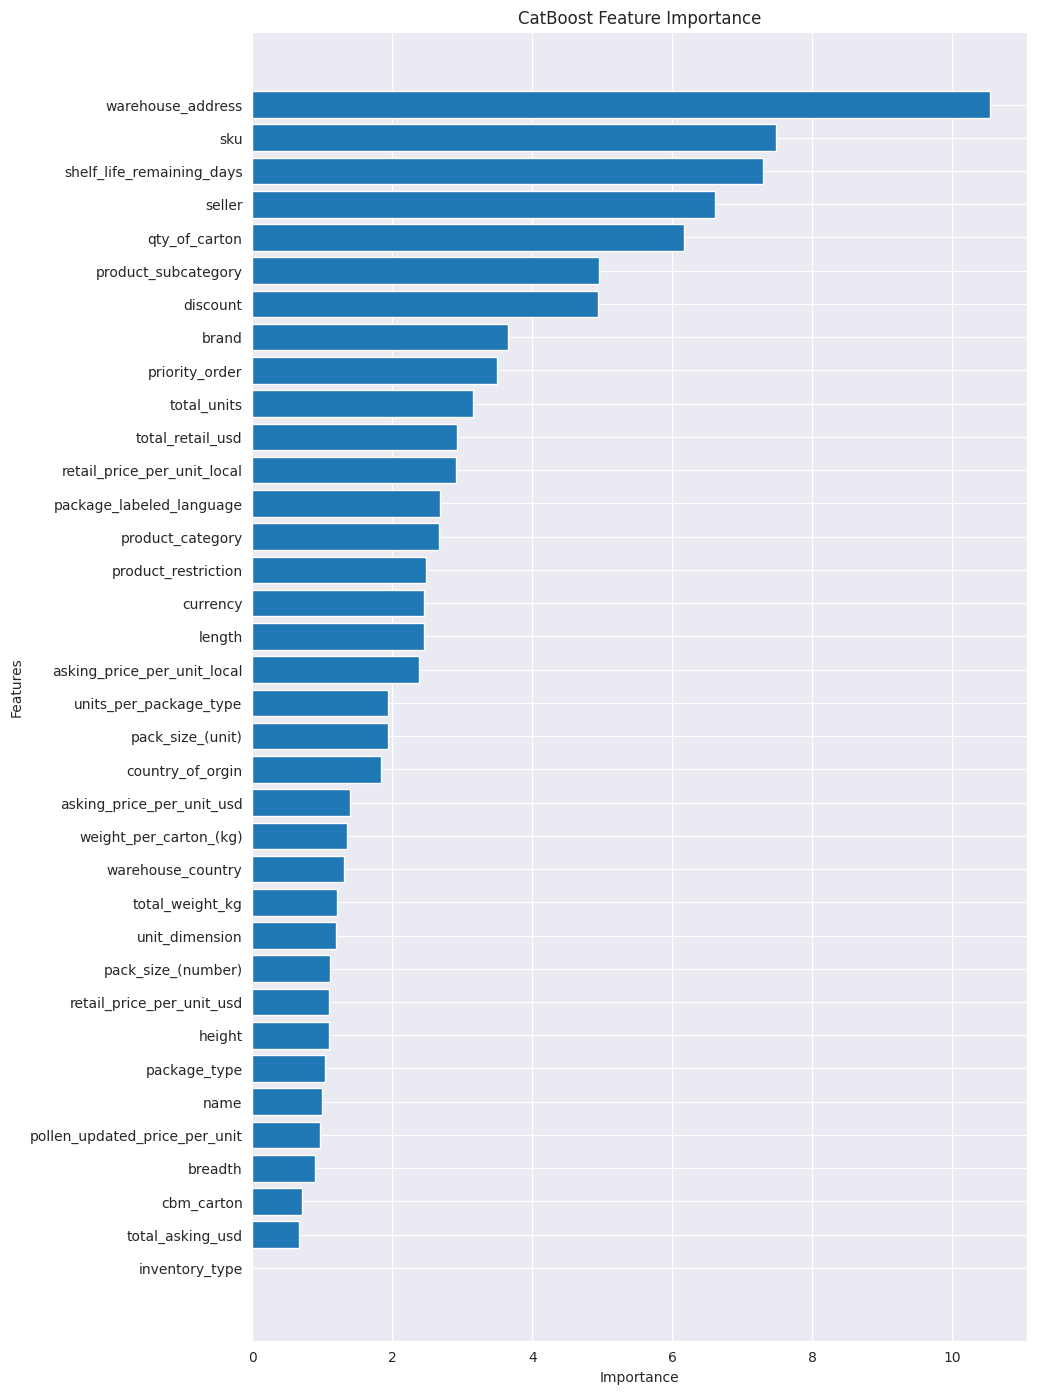

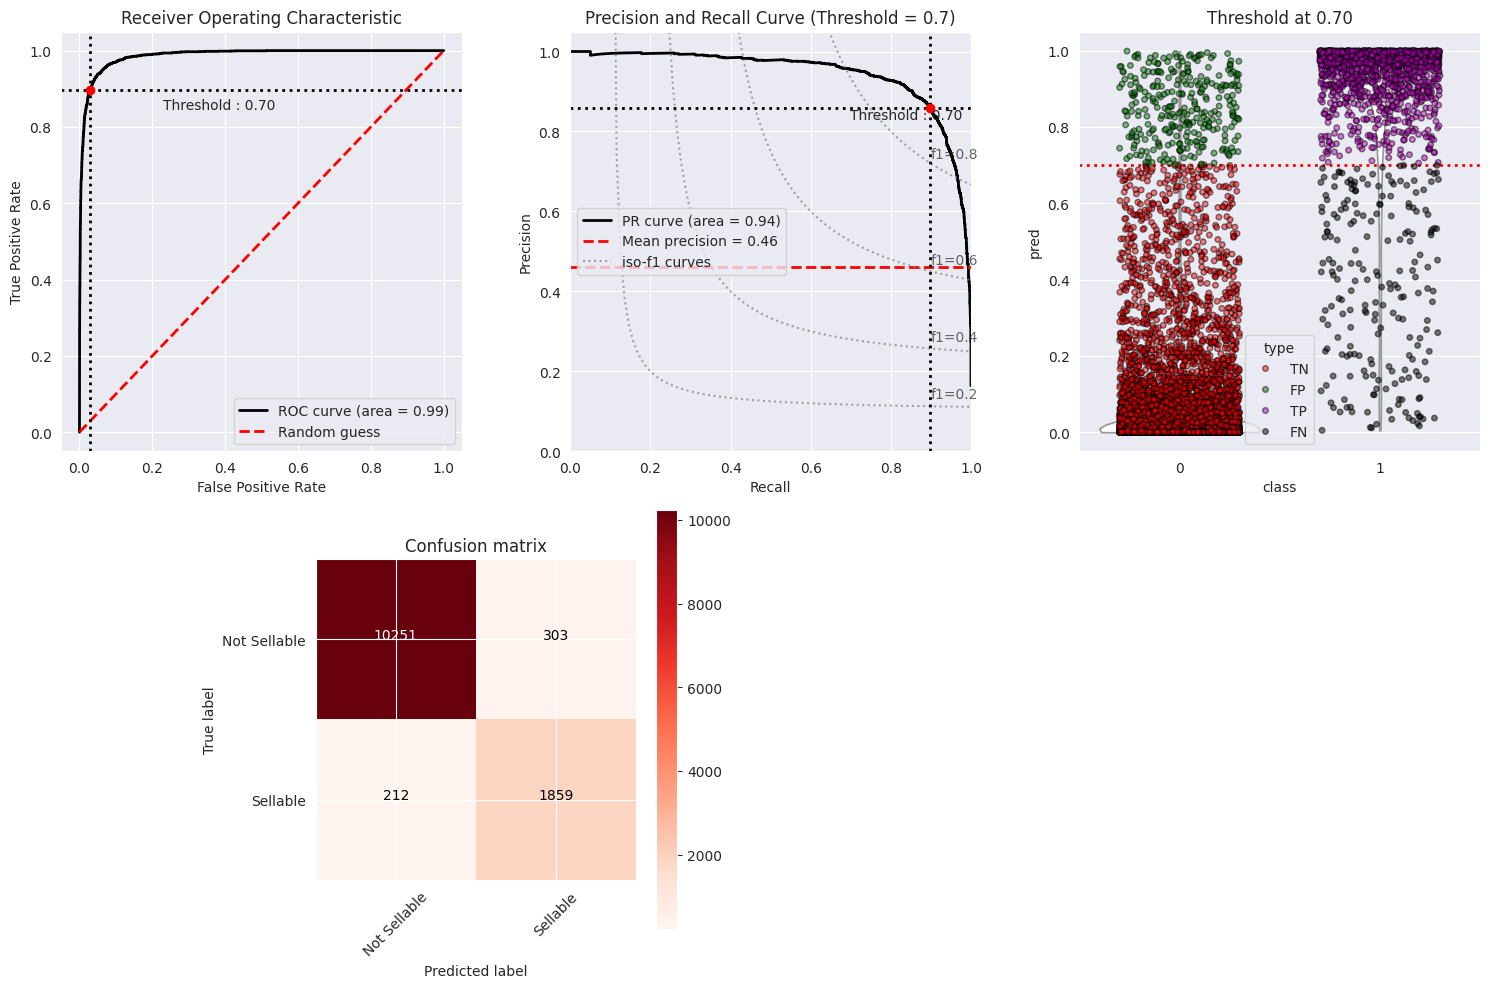

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

Not Sellable       0.98      0.97      0.98     10554
    Sellable       0.86      0.90      0.88      2071

    accuracy                           0.96     12625
   macro avg       0.92      0.93      0.93     12625
weighted avg       0.96      0.96      0.96     12625



In [ ]:
from catboost import CatBoostClassifier, Pool

train_data = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_cols,
    weight = np.where(X_train['total_asking_usd'] > 1000, 2, 1)
)

eval_data = Pool(
    data = X_val,
    label = y_val,
    cat_features = cat_cols,
    weight = np.where(X_val['total_asking_usd'] > 1000, 2, 1)
)

listing_model_params = {'loss_function': 'Logloss',
          'od_wait' : 100,
          'learning_rate': 0.2,
          'colsample_bylevel': 0.6,
          'depth': 4,
          'min_data_in_leaf': 35,
          'subsample': 0.6,
          'custom_metric' : 'AUC:hints=skip_train~false'}

model = CatBoostClassifier(**listing_model_params, iterations = 500, eval_metric = 'Precision', random_state = 7, auto_class_weights = 'Balanced')
model.fit(X=train_data, eval_set=eval_data)
pred_probs = model.predict_proba(X_val.values)
feature_importances = plot_feature_importances(model, X_train)
plot_mterics_report(y_val, pred_probs, t = THRESHOLD)

In [ ]:
df_inv_test = df_inv_test.reset_index(drop = True)
record_date = df_inv_test['record_date']

In [ ]:
df_inv_test = df_inv_test[train_cols]
df_inv_test['priority_order'] = df_inv_test['priority_order'].fillna(X_train['priority_order'].mode()[0])

In [ ]:
df_inv_test['probs'] = model.predict_proba(df_inv_test[train_cols].values)[:,1]*100

In [ ]:
MONTH = 'November'
date_for_filter = '2024-11-01'
path = '/content/drive/MyDrive/' + MONTH + '_Results/' + 'non_core_scoring_' + MONTH.lower() +'.xlsx'
print(path)
print(date_for_filter)

/content/drive/MyDrive/November_Results/non_core_scoring_november.xlsx
2024-11-01


In [ ]:
df_inv_test['record_date'] = record_date
temp = list(df_inv_test.columns)
temp.remove('record_date')
df_inv_test = df_inv_test[['record_date'] + temp]

In [ ]:
final_non_core_results = df_inv_test[(df_inv_test.inventory_type == 'non_core') & (df_inv_test.record_date >= date_for_filter)].sort_values(by = 'probs', ascending = False)

In [ ]:
final_non_core_results.head(2)

,record_date,seller,sku,name,package_type,qty_of_carton,units_per_package_type,total_units,currency,retail_price_per_unit_local,asking_price_per_unit_local,pollen_updated_price_per_unit,pack_size_(number),pack_size_(unit),brand,product_category,product_subcategory,cbm_carton,length,breadth,height,unit_dimension,weight_per_carton_(kg),warehouse_address,warehouse_country,country_of_orgin,package_labeled_language,product_restriction,retail_price_per_unit_usd,asking_price_per_unit_usd,priority_order,total_weight_kg,total_asking_usd,total_retail_usd,discount,shelf_life_remaining_days,inventory_type,probs
2501,2024-11-19,eblo,L212A,lilybyred_am9_to_pm9_survival_penliner_natural...,pieces,NaN,NaN,80.0,idr,180000.0,72000.0,,NaN,-,lilybyred,makeup,eye_makeup,NaN,NaN,NaN,NaN,-,NaN,jakarta,indonesia,-,-,-,11.388005,4.555202,p2,NaN,364.416169,911.040422,60.0,493.0,non_core,55.304673
2467,2024-11-19,eblo,LTGLF12,lilybyred_glassy_layer_fixing_tint_12_#muscat_...,pieces,NaN,NaN,414.0,idr,172000.0,68800.0,,NaN,-,lilybyred,makeup,lip_makeup,NaN,NaN,NaN,NaN,-,NaN,jakarta,indonesia,-,-,-,10.881872,4.352749,p3,NaN,1802.037956,4505.094889,60.0,408.0,non_core,51.587453


In [ ]:
final_non_core_results.shape

(253, 38)

In [ ]:
final_non_core_results.to_excel(path)

In [ ]:
# COLS_TO_CHECK_SIMILARITY_WITH = ['seller', 'sku_number', 'brand', 'product_category', 'product_subcategory', 'total_units', 'total_retail_price_(usd)',
#                                  'total_asking_price_(usd)', 'discount_%']

# df_inv = df_inv[['updated_on'] + COLS_TO_CHECK_SIMILARITY_WITH + ['sellability']]
# df_inv = df_inv.reset_index(drop = True)
# non_core_inv = non_core_inv[['updated_on'] + COLS_TO_CHECK_SIMILARITY_WITH + ['sellability']]
# non_core_inv = non_core_inv.reset_index(drop = True)

In [ ]:
# def get_mapping(df, feat):
#   temp = df.groupby(feat).agg({'sellability' : ['sum', 'size']}).reset_index()
#   temp.columns = temp.columns.droplevel()
#   temp[feat + '_encoding'] = temp['sum'] / temp['size']
#   temp = temp.rename(columns = {'' : feat})
#   temp = temp[[feat, feat + '_encoding']]
#   return temp

In [ ]:
# n_days_before_date = pd.to_datetime(date.today() - timedelta(days = 45))
# print(n_days_before_date)

# train = df_inv[df_inv.updated_on <= n_days_before_date].reset_index(drop = True)
# test = df_inv[df_inv.updated_on > n_days_before_date].reset_index(drop = True)

# seller_mapping = get_mapping(train, 'seller')
# product_category_mapping = get_mapping(train, 'product_category')
# brand_mapping = get_mapping(train, 'brand')
# sku_number_mapping = get_mapping(train, 'sku_number')
# product_subcategory_mapping = get_mapping(train, 'product_subcategory')

# Ask CS for inconsistency

In [ ]:
original_test = test.copy()
original_test = original_test.drop('sellability', axis = 1)
train_sellability = train['sellability']

train = train.drop(['updated_on', 'sellability'], axis = 1)
test = test.drop(['updated_on', 'sellability'], axis = 1)

In [ ]:
def apply_mapping(df):
  df['seller'] = df['seller'].map(dict(seller_mapping.values))
  df['product_category'] = df['product_category'].map(dict(product_category_mapping.values))
  df['brand'] = df['brand'].map(dict(brand_mapping.values))
  df['sku_number'] = df['sku_number'].map(dict(sku_number_mapping.values))
  df['product_subcategory'] = df['product_subcategory'].map(dict(product_subcategory_mapping.values))
  return df

In [ ]:
train = apply_mapping(train)
test = apply_mapping(test)

In [ ]:
train['discount_%'] = train['discount_%'].fillna(train['discount_%'].median())

test['seller'] = test['seller'].fillna(train['seller'].median())
test['sku_number'] = test['sku_number'].fillna(train['sku_number'].median())
test['brand'] = test['brand'].fillna(train['brand'].median())
test['product_category'] = test['product_category'].fillna(train['product_category'].median())
test['product_subcategory'] = test['product_subcategory'].fillna(train['product_subcategory'].median())

In [ ]:
print(train.shape, test.shape)

(41680, 9) (5677, 9)


In [ ]:
train.sample(2)

,seller,sku_number,brand,product_category,product_subcategory,total_units,total_retail_price_(usd),total_asking_price_(usd),discount_%
30180,0.0,0.0,0.0,0.000000,0.0,48.0,840.960000,420.480000,50.0
38848,0.0,0.0,0.0,0.009797,0.0,2.0,17.375083,3.475017,80.0


In [ ]:
test.sample(2)

,seller,sku_number,brand,product_category,product_subcategory,total_units,total_retail_price_(usd),total_asking_price_(usd),discount_%
5333,0.096994,0.0,0.100518,0.173139,0.150911,46080.0,2979.753569,2199.058134,26.2
685,0.096994,0.0,0.100518,0.078726,0.069531,264.0,2196.610000,878.640000,60.0


In [ ]:
train = train[['seller', 'sku_number', 'brand', 'product_category', 'product_subcategory']]
test = test[['seller', 'sku_number', 'brand', 'product_category', 'product_subcategory']]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler

X = np.array(train)
Y = np.array(test)

scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.transform(Y)

print(X.shape, Y.shape)
similarity_mat = cosine_similarity(X, Y)
print(similarity_mat.shape)

(41680, 5) (5677, 5)
(41680, 5677)


In [ ]:
similarity_df = pd.DataFrame(similarity_mat)
similarity_df['sellability'] = train_sellability

In [ ]:
similarity_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,...,5428,5429,5430,5431,5432,5433,5434,5435,5436,5437,5438,5439,5440,5441,5442,5443,5444,5445,5446,5447,5448,5449,5450,5451,5452,5453,5454,5455,5456,5457,5458,5459,5460,5461,5462,5463,5464,5465,5466,5467,5468,5469,5470,5471,5472,5473,5474,5475,5476,5477,5478,5479,5480,5481,5482,5483,5484,5485,5486,5487,5488,5489,5490,5491,5492,5493,5494,5495,5496,5497,5498,5499,5500,5501,5502,5503,5504,5505,5506,5507,5508,5509,5510,5511,5512,5513,5514,5515,5516,5517,5518,5519,5520,5521,5522,5523,5524,5525,5526,5527,5528,5529,5530,5531,5532,5533,5534,5535,5536,5537,5538,5539,5540,5541,5542,5543,5544,5545,5546,5547,5548,5549,5550,5551,5552,5553,5554,5555,5556,5557,5558,5559,5560,5561,5562,5563,5564,5565,5566,5567,5568,5569,5570,5571,5572,5573,5574,5575,5576,5577,5578,5579,5580,5581,5582,5583,5584,5585,5586,5587,5588,5589,5590,5591,5592,5593,5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,5616,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626,5627,5628,5629,5630,5631,5632,5633,5634,5635,5636,5637,5638,5639,5640,5641,5642,5643,5644,5645,5646,5647,5648,5649,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659,5660,5661,5662,5663,5664,5665,5666,5667,5668,5669,5670,5671,5672,5673,5674,5675,5676,sellability
0,-0.919341,0.306695,0.306695,0.496959,0.496959,-0.392560,0.469184,0.896945,0.935991,0.710643,-0.914040,-0.307140,-0.096271,0.284018,0.690663,0.869498,0.908297,0.842633,0.889384,-0.919341,-0.799853,0.333136,0.327819,0.920368,-0.545287,0.826053,0.933565,-0.548143,-0.558218,-0.548143,-0.548143,0.499154,0.499154,-0.548143,-0.389298,-0.914040,-0.352852,-0.548143,-0.914040,0.923046,0.613441,-0.548143,0.778749,-0.058023,-0.548143,-0.919341,-0.655917,-0.463639,-0.548143,-0.919341,-0.919341,-0.548143,-0.934890,0.647583,-0.548143,-0.914040,-0.914040,-0.548143,0.723301,-0.914040,0.333136,-0.934890,-0.548143,-0.472354,-0.548143,0.333136,-0.236327,-0.548143,-0.548143,-0.548143,-0.548143,-0.548143,-0.548143,0.839330,0.640520,0.640520,-0.528315,-0.548143,-0.914040,-0.914040,0.579151,0.579151,-0.545287,-0.548143,-0.548143,-0.729301,-0.458493,-0.528315,-0.472354,-0.914040,-0.548143,-0.548143,-0.919341,-0.655917,-0.548143,-0.934890,-0.548143,-0.528315,-0.934890,-0.914040,-0.548143,-0.914040,-0.548143,-0.914040,-0.914040,-0.914040,-0.914040,0.514938,-0.458493,-0.914040,-0.548143,-0.787439,-0.548143,-0.419551,-0.452688,-0.548143,0.257517,-0.548143,-0.548143,-0.914040,-0.548143,-0.528315,-0.548143,-0.753351,-0.548143,-0.452688,-0.528315,-0.545287,-0.919341,-0.934890,-0.548143,-0.548143,-0.914040,-0.914040,-0.914040,-0.914040,-0.548143,0.682467,-0.545287,-0.472354,-0.548143,-0.753351,-0.934890,-0.545287,-0.914040,-0.914040,-0.787439,0.492494,-0.919341,-0.914040,-0.919341,-0.545287,-0.934890,-0.548143,-0.914040,-0.914040,-0.548143,-0.914040,-0.934890,-0.914040,-0.919341,-0.919341,-0.914040,-0.914040,-0.914040,-0.934890,-0.772258,0.340227,-0.914040,-0.914040,-0.774629,-0.548143,-0.655917,0.889471,-0.914040,-0.548143,-0.914040,-0.914040,-0.459564,-0.375063,-0.548143,-0.165606,-0.548143,-0.914040,-0.914040,-0.548143,-0.514626,-0.934890,-0.91

In [ ]:
K = 10
net_test_sellability = []

for i in range(test.shape[0]):
  a = similarity_df[[i, 'sellability']].values
  a = a[a[:, 0].argsort()][-K:]
  net_test_sellability.append(np.multiply(a[:,0], a[:,1]).sum() / a[:,0].sum())

In [ ]:
original_test['score'] = net_test_sellability
original_test['score'] = original_test['score']*100

CORE_SELLERS = ['ulid', 'loid', 'ulth', 'ulmy', 'ulsg', 'loth', 'lomy']
original_test = original_test[~original_test.seller.isin(CORE_SELLERS)]

In [ ]:
original_test = original_test.sort_values(by = 'score', ascending = False)

# Filter current month test data

In [ ]:
original_test[original_test.updated_on >= '2024-10-01']

,updated_on,seller,sku_number,brand,product_category,product_subcategory,total_units,total_retail_price_(usd),total_asking_price_(usd),discount_%,score
5658,2024-10-15,borwita,BW0037,ambipur,other,other,90.0,186.428271,11.185709,93.999993,10.0
5553,2024-10-10,eblo,L260A,lilybyred,makeup,lip_makeup,83.0,983.682514,393.473005,60.000000,0.0
5560,2024-10-10,eblo,L276A,lilybyred,makeup,lip_makeup,196.0,2322.912924,929.165169,60.000000,0.0
5559,2024-10-10,eblo,L275A,lilybyred,makeup,lip_makeup,192.0,2275.506538,910.202615,60.000000,0.0
5558,2024-10-10,eblo,L274A,lilybyred,makeup,lip_makeup,179.0,2121.435782,848.574313,60.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5477,2024-10-10,eblo,L110A,lilybyred,makeup,lip_makeup,24.0,229.385740,91.754296,60.000000,0.0
5476,2024-10-10,eblo,L109A,lilybyred,makeup,lip_makeup,13.0,124.250609,49.700244,60.000000,0.0
5475,2024-10-10,eblo,L107A,lilybyred,makeup,lip_makeup,18.0,172.039305,68.815722,60.000000,0.0
5474,2024-10-10,eblo,L105A,lilybyred,makeup,lip_makeup,85.0,812.407828,324.963131,60.000000,0.0


In [ ]:
MONTH = 'October'
PATH = '/content/drive/MyDrive/' + MONTH + '_Results/' + MONTH + '_Non_Core' + '/NON_CORE_INV_FINAL_SCORES.xlsx'
print(PATH)

original_test[original_test.updated_on >= '2024-10-01'].to_excel(PATH)

/content/drive/MyDrive/October_Results/October_Non_Core/NON_CORE_INV_FINAL_SCORES.xlsx
